In [1]:
# ! pip install zuko

In [2]:
import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/n/sw/eb/apps/centos7/Anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Jets

In [5]:
from jetnet.datasets import JetNet, TopTagging

particle_data, jet_data = JetNet.getData(jet_type=["t"], data_dir="../data/", num_particles=30)

In [6]:
# Only select jets with 30 constituents for now
only_30_idx = jet_data[:, -1] == 30

x = torch.Tensor(particle_data[only_30_idx, :, :3])
mask = torch.Tensor(particle_data[only_30_idx, :, 3:])

mask[mask > 0] = 1
mask[mask < 0] = 0

## Flow matching with transformer

In [7]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping

from torch.utils.data import TensorDataset, DataLoader, random_split

/n/home11/smsharma/.local/lib/python3.9/site-packages/torch/distributed/_shard/partial_tensor.py:40: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)


In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch import Tensor
from torch.distributions import Normal
from tqdm import tqdm
from typing import *

from zuko.utils import odeint
from models.transformer import Transformer

In [9]:
# Test transformer

net = Transformer(emb=128, heads=2, depth=3, seq_length=30, mask=False)
x_test = x[:64]
x_emb = nn.Linear(3, 128)(x_test)
net(x_emb).shape

torch.Size([64, 30, 128])

In [10]:
class CNF(nn.Module):
    def __init__(
        self,
        features: int,
        frequencies: int = 6,
        embedding_dim: int = 128,
        **kwargs
    ):
        super().__init__()
        
        

        self.net = Transformer(emb=embedding_dim, mask=False, **kwargs)
        self.emb = nn.Linear(features + 2 * frequencies, embedding_dim)
        self.demb = nn.Linear(embedding_dim, features)
        
        self.register_buffer('frequencies', 2 ** torch.arange(frequencies) * torch.pi)

    def forward(self, t: Tensor, x: Tensor) -> Tensor:
        t = self.frequencies * t[..., None]
        t = torch.cat((t.cos(), t.sin()), dim=-1)
        t = t.expand(*x.shape[:-1], -1)
        
        x = torch.cat((t, x), dim=-1)
        
        x = self.emb(x)
        x = self.net(x)
        x = self.demb(x)
        
        return x

    def encode(self, x: Tensor) -> Tensor:
        return odeint(self, x, 0.0, 1.0, phi=self.parameters())

    def decode(self, z: Tensor) -> Tensor:
        return odeint(self, z, 1.0, 0.0, phi=self.parameters())

    def log_prob(self, x: Tensor) -> Tensor:
        I = torch.eye(x.shape[-1]).to(x)
        I = I.expand(x.shape + x.shape[-1:]).movedim(-1, 0)

        def augmented(t: Tensor, x: Tensor, ladj: Tensor) -> Tensor:
            with torch.enable_grad():
                x = x.requires_grad_()
                dx = self(t, x)

            jacobian = torch.autograd.grad(dx, x, I, is_grads_batched=True, create_graph=True)[0]
            trace = torch.einsum('i...i', jacobian)

            return dx, trace * 1e-2

        ladj = torch.zeros_like(x[..., 0])
        z, ladj = odeint(augmented, (x, ladj), 0.0, 1.0, phi=self.parameters())

        return Normal(0.0, z.new_tensor(1.0)).log_prob(z).sum(dim=-1) + ladj * 1e2


class FlowMatchingLoss(nn.Module):
    def __init__(self, v: nn.Module):
        super().__init__()

        self.v = v

    def forward(self, x: Tensor) -> Tensor:
        t = torch.rand_like(x[..., 0]).unsqueeze(-1)
        z = torch.randn_like(x)
        y = (1 - t) * x + (1e-4 + (1 - 1e-4) * t) * z
        u = (1 - 1e-4) * z - x

        return (self.v(t.squeeze(-1), y) - u).square().mean()
    
    
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

    
class SetFlowMatching(pl.LightningModule):

    def __init__(self, optimizer=torch.optim.AdamW, 
                       optimizer_kwargs={"weight_decay":1e-5}, 
                       lr=8e-4, 
                       scheduler=CosineWarmupScheduler,
                       scheduler_kwargs={"warmup":1000, "max_iters":20000},
                       features=3,
                       embedding_dim=128,
                       **kwargs):
        
        super().__init__()
        
        self.optimizer = optimizer
        self.optimizer_kwargs = optimizer_kwargs
        self.scheduler = scheduler
        self.scheduler_kwargs = scheduler_kwargs
        self.lr = lr
        
        self.flow = CNF(features=features, embedding_dim=embedding_dim, **kwargs)
        self.loss = FlowMatchingLoss(self.flow)
                
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        
        return {"optimizer": optimizer, 
                    "lr_scheduler": {
                    "scheduler": self.scheduler(optimizer, **self.scheduler_kwargs),
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
            
    def training_step(self, batch, batch_idx):
        x, mask = batch
        loss = self.loss(x)     
        self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, mask = batch
        loss = self.loss(x)     
        self.log('val_loss', loss, on_epoch=True)
        return loss

In [11]:
batch_size = 128

val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, mask)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False)

In [12]:
max_epochs = 6
kwargs = {"heads":4, "depth":4, "seq_length":30}
model = SetFlowMatching(features=3, embedding_dim=256, scheduler_kwargs = {"warmup":1, "max_iters":max_epochs * len(train_loader)}, **kwargs)
# model = torch.compile(model)

In [13]:
# Lightning callbacks
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", every_n_epochs=4, save_top_k=1)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=6)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

torch.set_float32_matmul_precision('medium')

In [14]:
# Instantiate trainer
trainer = pl.Trainer(max_epochs=max_epochs, accelerator='gpu', devices=1, gradient_clip_val=1., callbacks=[checkpoint_callback, lr_monitor, early_stop_callback])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/n/home11/smsharma/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/sw/eb/apps/centos7/Anaconda3/2022.05/lib/python3. ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/n/home11/smsharma/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/sw/eb/apps/centos7/Anaconda3/2022.05/lib/python3. ...
  rank_zero_warn(
/n/home11/smsharma/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/mode

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.


## Generation

In [15]:
model.eval().cuda();

In [16]:
n_samples = 100
n_particles = 30

with torch.no_grad():
    z = torch.randn(n_samples, n_particles, 3).cuda()
    x_samples = model.flow.decode(z).cpu().numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.34it/s]
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif


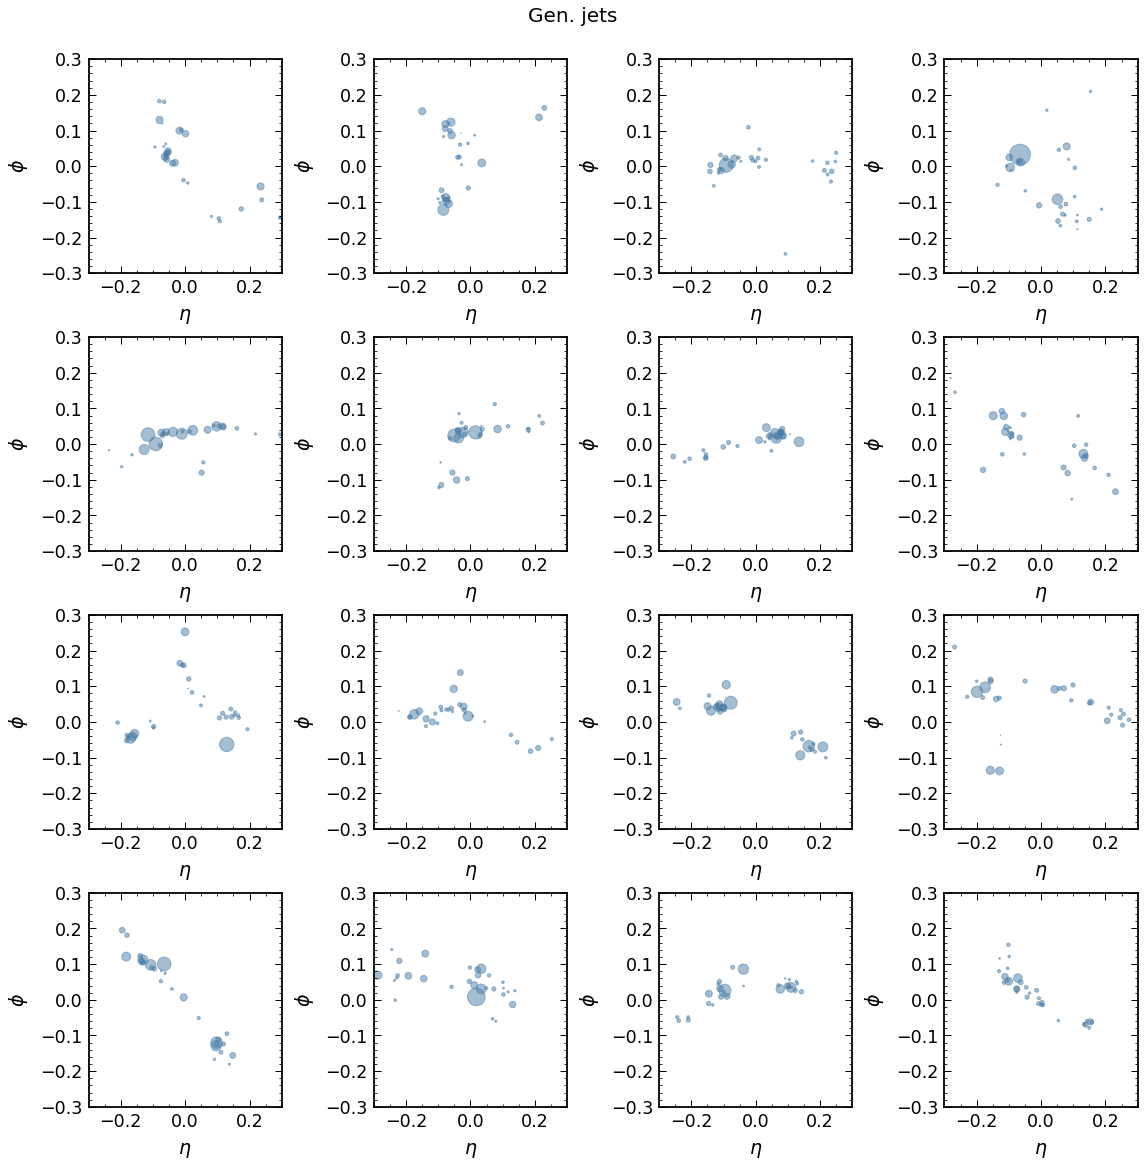

In [17]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])
        
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * np.abs(x_samples[i, :, 2]), alpha=0.5, color=cols_default[1]) 
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()

In [18]:
import energyflow as ef

def jet_masses(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    masses = ef.ms_from_p4s(jets_p4s.sum(axis=1))
    return masses

def jet_ys(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    ys = ef.ys_from_p4s(jets_p4s.sum(axis=1))
    return ys

def jet_etas(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    etas = ef.etas_from_p4s(jets_p4s.sum(axis=1))
    return etas

def jet_phis(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    phis = ef.phis_from_p4s(jets_p4s.sum(axis=1), phi_ref=0)
    return phis

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif


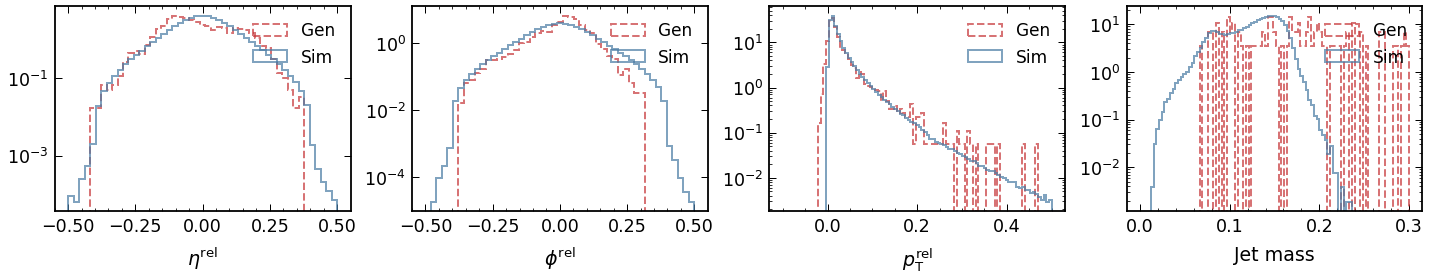

In [19]:
fig = plt.figure(figsize=(20, 4))
gs = GridSpec(1, 4)

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = (np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.5, 100)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[3])

bins= np.linspace(0., 0.3, 100)

jet_mass = jet_masses(np.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
ax.hist(jet_mass, histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

jet_mass = jet_masses(np.array([x.numpy()[:, :, 2], x.numpy()[:, :, 0], x.numpy()[:, :, 1]]).transpose(1,2,0))
ax.hist(jet_mass, histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"Jet mass")
ax.set_yscale("log")
ax.legend()


plt.tight_layout()